In [1]:
# Author Zhongjian
# Code adapted from HZY's Darcy code
# Modified to 3d, Feb 18
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import sys
sys.path.append('./codes/')
from utils import Gaussian_random_field_3d

##
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plt_2d_compare(*mats):
    nmat = len(mats)
    fig, axes = plt.subplots(1, nmat)
    fig.subplots_adjust(wspace=0.5)
    for ia in range(nmat):
        ax = axes[ia]
        im=ax.imshow(mats[ia])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad="5%")
        fig.colorbar(im,cax)
    plt.show()

##
def compute_obs_3d(h_3d):
    obs_ΔN = 4
    return h_3d[2::obs_ΔN, 2::obs_ΔN,2::obs_ΔN].flatten()

## Generate Data on server
def generate_single(theta,grf):
    logk_3d = grf.generate(theta)
    obs_noiseless = compute_obs_3d(logk_3d)
    return obs_noiseless,logk_3d


In [2]:
N_training =10000
N_test = 100
N_KL = 64 # 6*6*6-1
L=1
N=21
np.random.seed(0)
save_path='./data/identity3d'
xx = np.linspace(0, L, N,endpoint=True)
X,Y,Z= np.meshgrid(xx, xx,xx)
grf = Gaussian_random_field_3d(xx, N_KL, d=2.5, tau=5.0, sigma=5**(2.0))


In [3]:
## Reference field
sigma=2e-1
theta = np.random.normal(0, 1, N_KL)
obs_noiseless,logk_3d = generate_single(theta,grf)
obs_pos_X,obs_pos_Y,obs_pos_Z =compute_obs_3d(X),compute_obs_3d(Y),compute_obs_3d(Z)
obs_sz= obs_pos_X.shape
obs = obs_noiseless +sigma*np.random.normal(0,1,obs_sz)
ref = logk_3d

ref_pos=np.array([X.flatten(),Y.flatten(),Z.flatten()]).T
obs_pos=np.array([obs_pos_X,obs_pos_Y,obs_pos_Z]).T
# print(obs_pos.shape)
# Y is conditional data
CXY=grf.compute_covmat(ref_pos,obs_pos)
CXX=grf.compute_covmat(ref_pos,ref_pos)
CYY=grf.compute_covmat(obs_pos,obs_pos)
CYX=CXY.T
mean_sol = CXY@np.linalg.solve(CYY+np.eye(obs_sz[0])*sigma**2,obs)
mean_sol2d=mean_sol.reshape(N,N,N)
cov_sol = CXX-CXY@np.linalg.solve(CYY+np.eye(obs_sz[0])*sigma**2,CYX)
var_sol2d = np.diag(cov_sol).reshape(N,N,N)

with open(save_path+'/test.npy', 'wb') as f:
    np.save(f, obs)
    np.save(f, ref)
    np.save(f, mean_sol2d)
    np.save(f, var_sol2d)

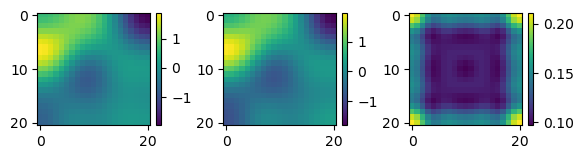

In [4]:
# Comparision, reference field, bayesian mean, bayesian std
plt_2d_compare(ref[N//2,:,:],mean_sol2d[N//2,:,:],np.sqrt(var_sol2d[N//2,:,:]))

In [5]:
# Set 1 

obs_noiseless_all = []
logk_3d_all = []
for i in tqdm(range(N_training)):
    theta = np.random.normal(0, 1, N_KL)
    obs_noiseless,logk_3d = generate_single(theta,grf)
    obs_noiseless_all.append(obs_noiseless)
    logk_3d_all.append(logk_3d)
logk_3d_all=np.array(logk_3d_all)
obs_noiseless_all=np.array(obs_noiseless_all)
with open(save_path+'/data_set.npy', 'wb') as f:
    np.save(f, logk_3d_all)
    np.save(f, obs_noiseless_all)
# Set 2     
        
obs_noiseless_all = []
logk_3d_all = []
for i in tqdm(range(N_test)):
    theta = np.random.normal(0, 1, N_KL)
    obs_noiseless,logk_2d = generate_single(theta,grf)
    obs_noiseless_all.append(obs_noiseless)
    logk_3d_all.append(logk_2d)
logk_3d_all=np.array(logk_3d_all)
obs_noiseless_all=np.array(obs_noiseless_all)
with open(save_path+'/data_set_100.npy', 'wb') as f:
    np.save(f, logk_3d_all)
    np.save(f, obs_noiseless_all)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3268.07it/s]
